# Capstone Project: Board Games Recommender
____________

# Part 4 - Topic Modelling

### Riche Ngo, SG-DSI-18

In this notebook, we will explore how to use topic modelling techniques to analyze the data collected on the board game descriptions.

A [topic model](https://en.wikipedia.org/wiki/Topic_model) is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. In this context, the documents would be the board game descriptions. It is usually used for discovering hidden semantic structures in a text body. We do this to further improve our recommender system, utilizing the discovered topics as an extra "feature" for the board games. People using our recommender system may have the option of diversifying their board game recommendations based on the topic models developed. This may improve the user experience through discovery of a wider variety of board games, and also increase the attractiveness of the recommender system. Board game publishers with newer and less popular games may support this idea since it increases the chances of their board games being discovered by board gamers.

### Contents:
- [Preprocessing Text](#Preprocessing-Text)
- [Latent Dirichlet Allocation](#Latent-Dirichlet-Allocation)
- [Incorporation with Recommender](#Incorporation-with-Recommender)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json_lines
import pickle
import urllib
import sys
import re
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Import data

Import the cleaned dataframe, reference dictionaries.

In [2]:
# Open dataframe
infile = open('../datasets/boardgames/clean_bgg_GameItem.pkl', 'rb')
game_df = pickle.load(infile)
infile.close()

game_df.shape

(7929, 20)

In [3]:
# Open dictionaries
infile = open('../datasets/boardgames/ref_dictionaries.pkl', 'rb')
ref_dicts = pickle.load(infile)
infile.close()

In [4]:
# Read 10 lines of the .jl file to see what we are dealing with
with open('../datasets/boardgames/scraped_bgg_GameItem.jl', 'rb') as f:
    count = 1
    for item in json_lines.reader(f):
        print(count, item)
        print('\n\n\n-----------------------')
        count += 1
        if count == 10:
            break

1 {'add_rank': [{'bayes_rating': 7.27122, 'game_type': 'strategygames', 'game_type_id': 5497, 'name': 'Strategy Game', 'rank': 156}], 'alt_name': ['Die Macher', '德国大选', '디 마허'], 'artist': ['Marcus Gschwendtner:12517', 'Harald Lieske:4959'], 'avg_rating': 7.6308, 'bayes_rating': 7.14289, 'best_rating': 10, 'bgg_id': 1, 'category': ['Economic:1021', 'Negotiation:1026', 'Political:1001'], 'compilation': False, 'complexity': 4.3245, 'cooperative': False, 'description': 'Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regio

In [5]:
# Extract descriptions
description_dict = {}

with open('../datasets/boardgames/scraped_bgg_GameItem.jl', 'rb') as f:
    for item in json_lines.reader(f):
        try:
            description_dict[item['bgg_id']] = item['description']
        except:
            continue

In [6]:
# Dataframe with subset of features
bg_df = game_df[['bgg_id', 'name', 'bayes_rating']]

In [7]:
# Update dataframe to include the description
for i, row in bg_df.iterrows():
    bg_df.at[i, 'description'] = description_dict[row['bgg_id']]

C:\Users\riche\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\riche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
bg_df.head()

,bgg_id,name,bayes_rating,description
0,3,Samurai,7.24774,Samurai is set in medieval Japan. Players comp...
1,9,El Caballero,5.94897,"Although referred to as a sequel to El Grande,..."
2,10,Elfenland,6.50146,Elfenland is a redesign of the original White ...
3,11,Bohnanza,6.93425,Bohnanza is the first in the Bohnanza family o...
4,12,Ra,7.31246,Ra is an auction and set-collection game with ...


## Preprocessing Text

#### Initial cleaning of texts

We want to remove newline characters, punctuations, etc. and store the words into a list.

In [9]:
punctuation = punctuation + '—'

# Function to process descriptions into list of words
def generate_words(text):
    result = text.replace('/', '').replace('\n', ' ')   # removes newline chars
    result = re.sub(r'(\w)(\1{2,})', r'\1', result)
    result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
    result = ''.join(t for t in result if t not in punctuation)   # removes punctuation
    result = gensim.utils.simple_preprocess(str(result), deacc=True)   # lowercases, tokenizes, de-accents
    return result

In [10]:
# List of all the preprocessed descriptions
data_words = []
for text in bg_df['description']:
    data_words.append(generate_words(text))
    
print(data_words[:1])

[['samurai', 'is', 'set', 'in', 'medieval', 'japan', 'players', 'compete', 'to', 'gain', 'the', 'favor', 'of', 'three', 'factions', 'samurai', 'peasants', 'and', 'priests', 'which', 'are', 'represented', 'by', 'helmet', 'rice', 'paddy', 'and', 'buddha', 'figures', 'scattered', 'about', 'the', 'board', 'which', 'features', 'the', 'islands', 'of', 'japan', 'the', 'competition', 'is', 'waged', 'through', 'the', 'use', 'of', 'hexagonal', 'tiles', 'each', 'of', 'which', 'help', 'curry', 'favor', 'of', 'one', 'of', 'the', 'three', 'factions', 'or', 'all', 'three', 'at', 'once', 'players', 'can', 'make', 'lightningquick', 'strikes', 'with', 'horseback', 'ronin', 'and', 'ships', 'or', 'approach', 'their', 'conquests', 'more', 'methodically', 'as', 'each', 'figure', 'helmets', 'rice', 'paddies', 'and', 'buddhas', 'is', 'surrounded', 'it', 'is', 'awarded', 'to', 'the', 'player', 'who', 'has', 'gained', 'the', 'most', 'favor', 'with', 'the', 'corresponding', 'group', 'gameplay', 'continues', 'unt

#### Process text

We want to build bigram and trigram models and use them as a means to filter out words which are more significant across all the board game descriptions.

In [11]:
# Build the bigram and trigram models
# ignore all words and bigrams with total collected count lower than min_count
# threshold represents a threshold for forming the phrases (higher means fewer phrases)
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
stop_words = stopwords.words('english')

# Function to process text
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])   # !python3 -m spacy download en  # run in terminal once
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [13]:
# Processed text data
data_ready = process_words(data_words)

In [14]:
len(data_ready)

7929

In [15]:
data_ready[:1]

[['player',
  'compete',
  'gain',
  'favor',
  'faction',
  'peasant',
  'priest',
  'represent',
  'figure',
  'scatter',
  'board',
  'feature',
  'competition',
  'wage',
  'use',
  'hexagonal',
  'tile',
  'help',
  'curry',
  'favor',
  'faction',
  'player',
  'make',
  'lightningquick',
  'strike',
  'ship',
  'approach',
  'conquest',
  'methodically',
  'figure',
  'helmet',
  'rice',
  'paddy',
  'surround',
  'award',
  'player',
  'gain',
  'favor',
  'corresponding',
  'group',
  'gameplay',
  'continue',
  'symbol',
  'type',
  'remove',
  'board',
  'figure',
  'remove',
  'play',
  'due',
  'tie',
  'influence',
  'end',
  'game',
  'player',
  'compare',
  'capture',
  'symbol',
  'type',
  'competing',
  'majority',
  'type',
  'tie',
  'base',
  'number',
  'nonmajority',
  'symbol',
  'player',
  'collect',
  'game',
  'part',
  'sometimes',
  'call',
  'knizia',
  'trilogy']]

## Latent Dirichlet Allocation  

We use [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), a generative statistical model in natural language processing that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics.

#### Create corpus

We want to create a corpus from the list of texts.

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

#### Building the model

We use the `num_topics` argument to decide the number of requested latent topics to be extracted from the training corpus. It was first selected arbitarily, but after many iterations, we felt that the board games could be best represented by 9 major topics.

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,   # Mapping from word ids to words
                                           num_topics=9,   # Number of topics
                                           random_state=42,
                                           update_every=1,   # Number of documents to be iterated through for each update
                                           chunksize=100,   # Number of documents to be used in each training chunk
                                           passes=10,   # Number of passes through the corpus during training
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Print out the topics generated
pprint(lda_model.print_topics())

[(0,
  '0.040*"player" + 0.031*"build" + 0.026*"action" + 0.024*"resource" + '
  '0.019*"city" + 0.018*"good" + 0.018*"building" + 0.018*"point" + '
  '0.014*"phase" + 0.014*"end"'),
 (1,
  '0.091*"piece" + 0.043*"grid" + 0.031*"train" + 0.021*"street" + '
  '0.019*"circle" + 0.016*"ring" + 0.015*"car" + 0.015*"sky" + 0.015*"line" + '
  '0.012*"track"'),
 (2,
  '0.072*"game" + 0.024*"play" + 0.022*"new" + 0.022*"player" + 0.012*"card" + '
  '0.012*"use" + 0.011*"include" + 0.010*"rule" + 0.010*"hero" + '
  '0.010*"control"'),
 (3,
  '0.034*"unit" + 0.029*"battle" + 0.021*"war" + 0.020*"force" + '
  '0.020*"combat" + 0.016*"system" + 0.016*"attack" + 0.015*"fight" + '
  '0.014*"map" + 0.012*"turn"'),
 (4,
  '0.023*"player" + 0.020*"game" + 0.011*"time" + 0.010*"description" + '
  '0.010*"character" + 0.010*"take" + 0.009*"use" + 0.008*"must" + '
  '0.008*"ability" + 0.008*"make"'),
 (5,
  '0.029*"experience" + 0.021*"enemy" + 0.018*"word" + 0.015*"know" + '
  '0.015*"ally" + 0.014*"vill

We observe above the top 10 words represent each of the 9 topics and start to see generic words which are linked to one another in some ways. For example, the topic which comprises words "build", "building", "resource", suggests a common board game genre where players have to manage their resources throughout the game to construct buildings as a means of gaining better resources or scoring more points to win. Some of these topics may not be represented well enough in the board games' listed game types or categories. We can explore the generated topics more clearly with better visualizations below.

#### Dominant topics

We want to find out the dominant topic for each board game. Each board game (or document) comprises multiple topics but typically only one of the topics will be dominant. Using the contributions to each topic, we are able to find out the dominant topic for each board game descriptions for further exploration.

In [18]:
# Function to format topic sentences for the data
data = bg_df['description'].values.tolist()

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Dataframe to show the dominant topic for each board game
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.2979,"experience, enemy, word, know, ally, village, ...","[player, compete, gain, favor, faction, peasan..."
1,1,0.0,0.7129,"player, build, action, resource, city, good, b...","[refer, share, aspect, namesake, fun, intense,..."
2,2,6.0,0.3682,"card, player, point, game, play, turn, publish...","[redesign, original, white, set, mythical, wor..."
3,3,6.0,0.4781,"card, player, point, game, play, turn, publish...","[family, game, publish, several, different, ed..."
4,4,4.0,0.3642,"player, game, time, description, character, ta...","[auction, setcollection, game, ancient, egypti..."
5,5,0.0,0.3283,"player, build, action, resource, city, good, b...","[formerly, settler, player, try, building, set..."
6,6,6.0,0.4222,"card, player, point, game, play, turn, publish...","[gem, merchant, compete, marketplace, race, co..."
7,7,0.0,0.6134,"player, build, action, resource, city, good, b...","[take, role, shop, owner, moroccan, marketplac..."
8,8,4.0,0.7752,"player, game, time, description, character, ta...","[gain, quick, follow, major, gaming, conventio..."
9,9,2.0,0.4430,"game, play, new, player, card, use, include, r...","[player, control, race, must, juggle, military..."


In [20]:
# Append the dominant topic of each board game to the original dataframe
bg_df['topic_no'] = df_dominant_topic['Dominant_Topic'].astype(int)

# Save appended dataframe
outfile = open('../datasets/boardgames/bgg_games_topics.pkl', 'wb')
pickle.dump(bg_df, outfile)
outfile.close()

<ipython-input-20-1889e64ce4e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_df['topic_no'] = df_dominant_topic['Dominant_Topic'].astype(int)


### Visualizations

Further exploration of topic models and try to understand each topic more deeply.

#### Wordcloud

In [21]:
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

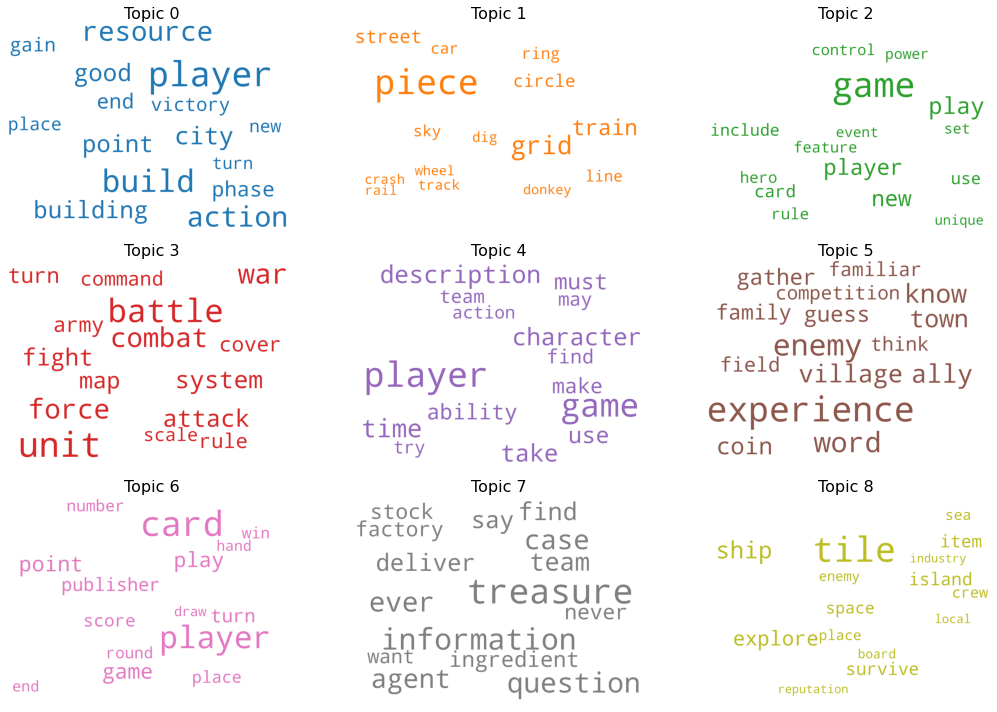

In [22]:
# Wordcloud of Top 15 words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='Set1',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words=15)

fig, axes = plt.subplots(3, 3, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()[:len(topics)]):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

# This code below is to switch off the unnecessary axes
for ax in axes.flat[len(topics):]:
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word clouds are an alternative method of viewing the topic keywords of each topic, with the size of each keyword proportional to the weights of each keyword. We are able to generalize the following for each topic:  
* **Topic 0:** Board games described by resource management and building.
* **Topic 1:** Board games described by using pieces to race against each other on a track, or grid of some sorts.
* **Topic 2:** Board games likely with players role-playing as a hero with unique powers.
* **Topic 3:** Board games likely carrying the theme of war, combat, or battle.
* **Topic 4:** Board games with player or character abilities, taking actions over time.
* **Topic 5:** Possibly family-oriented board games, where players need to form allies to compete against other teams.
* **Topic 6:** Board games that have more generic descriptions about how to score points, most of the time through cards.
* **Topic 7:** Board games about agents on a case, likely requiring players to collect information or ingerdients.
* **Topic 8:** Board games described by spatial components such as tiles, places, likely on the theme of sailing the seas, or space.

We are also able to observe some words that appear quite frequently across all the topics, such as "player", "game". These are usually common words used in board game descriptions.

#### Bar charts

In [23]:
from collections import Counter

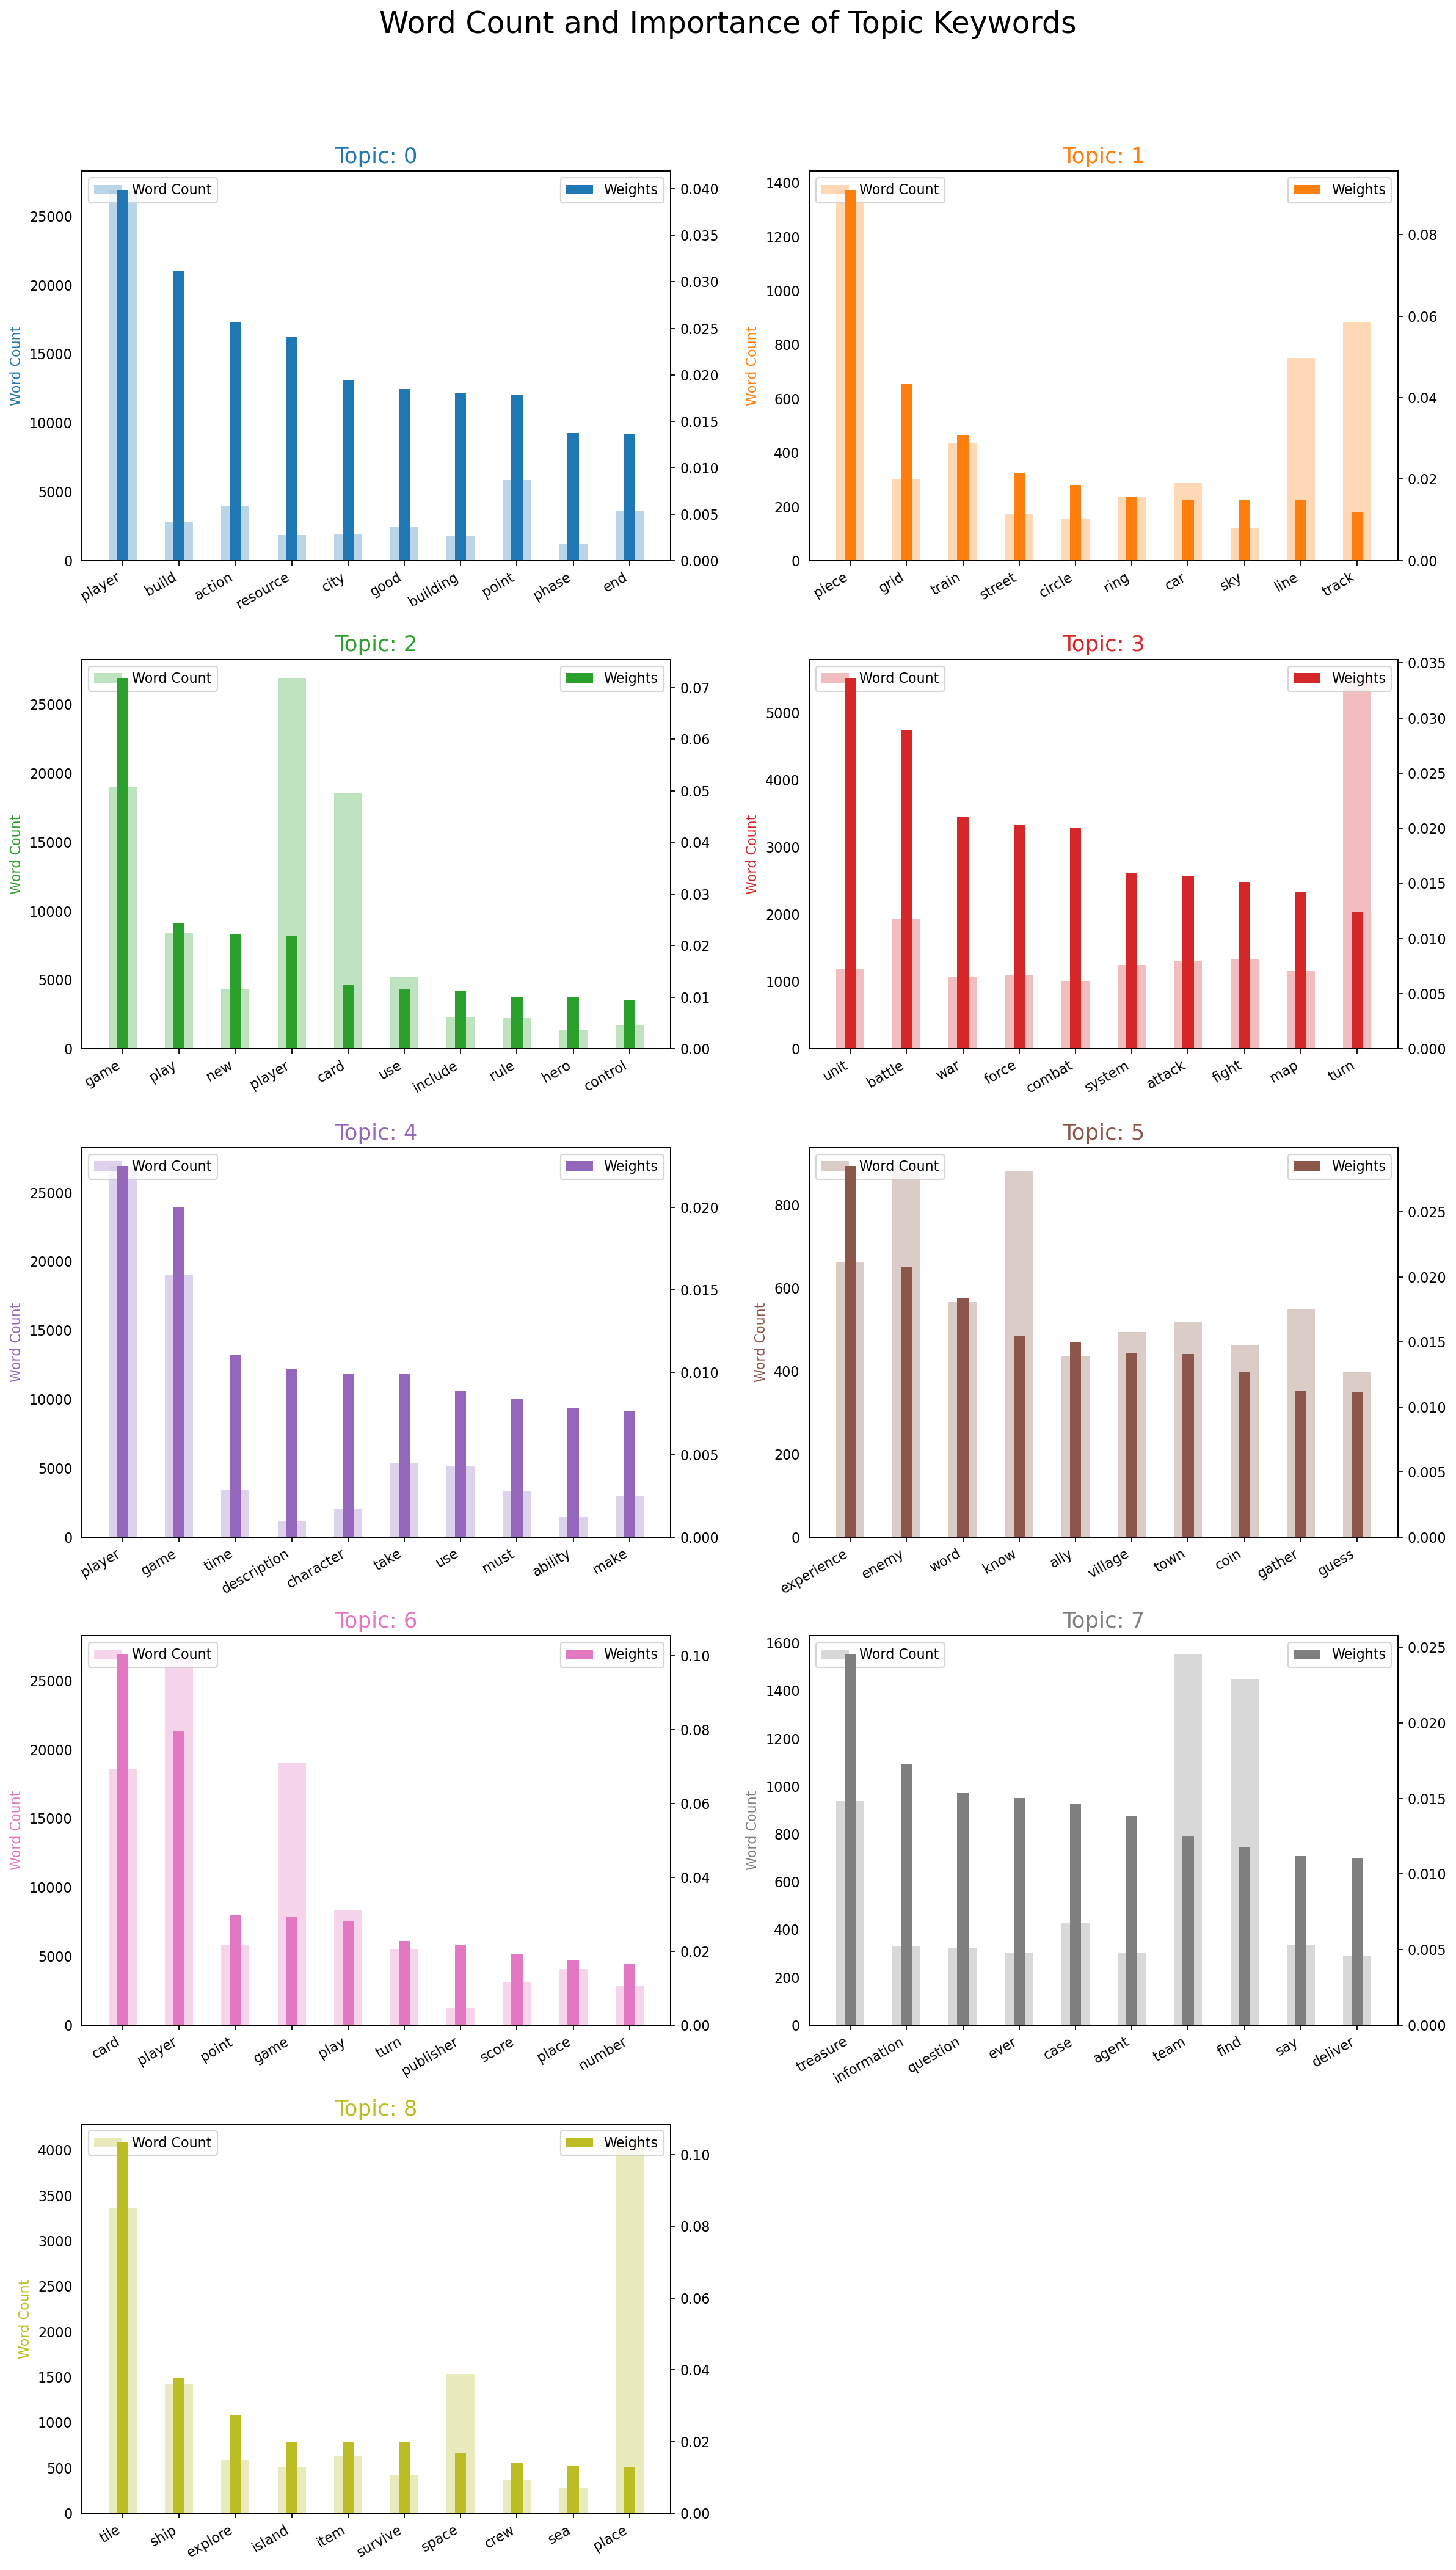

In [24]:
# Word count and importance of topic keywords
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(15,25), dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()[:len(topics)]):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# This code below is to switch off the unnecessary axes
for ax in axes.flat[len(topics):]:
    ax.axis('off')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The weights/importance of the keywords is observed alongside the frequency of each word appearing within each topic. For words that frequently appear across multiple topics (such as "player"), they usually turn out to be of less importance. We could also see the keywords with relative frequency is higher than the weight. For example, in Topic 8, "place" has a relatively high word count as compared to the actual importance of the word itself. This suggests that while the word appeared a lot within the board games of that dominant topic, it is not the best word used to differentiate this topic from the rest.

#### Frequency distribution

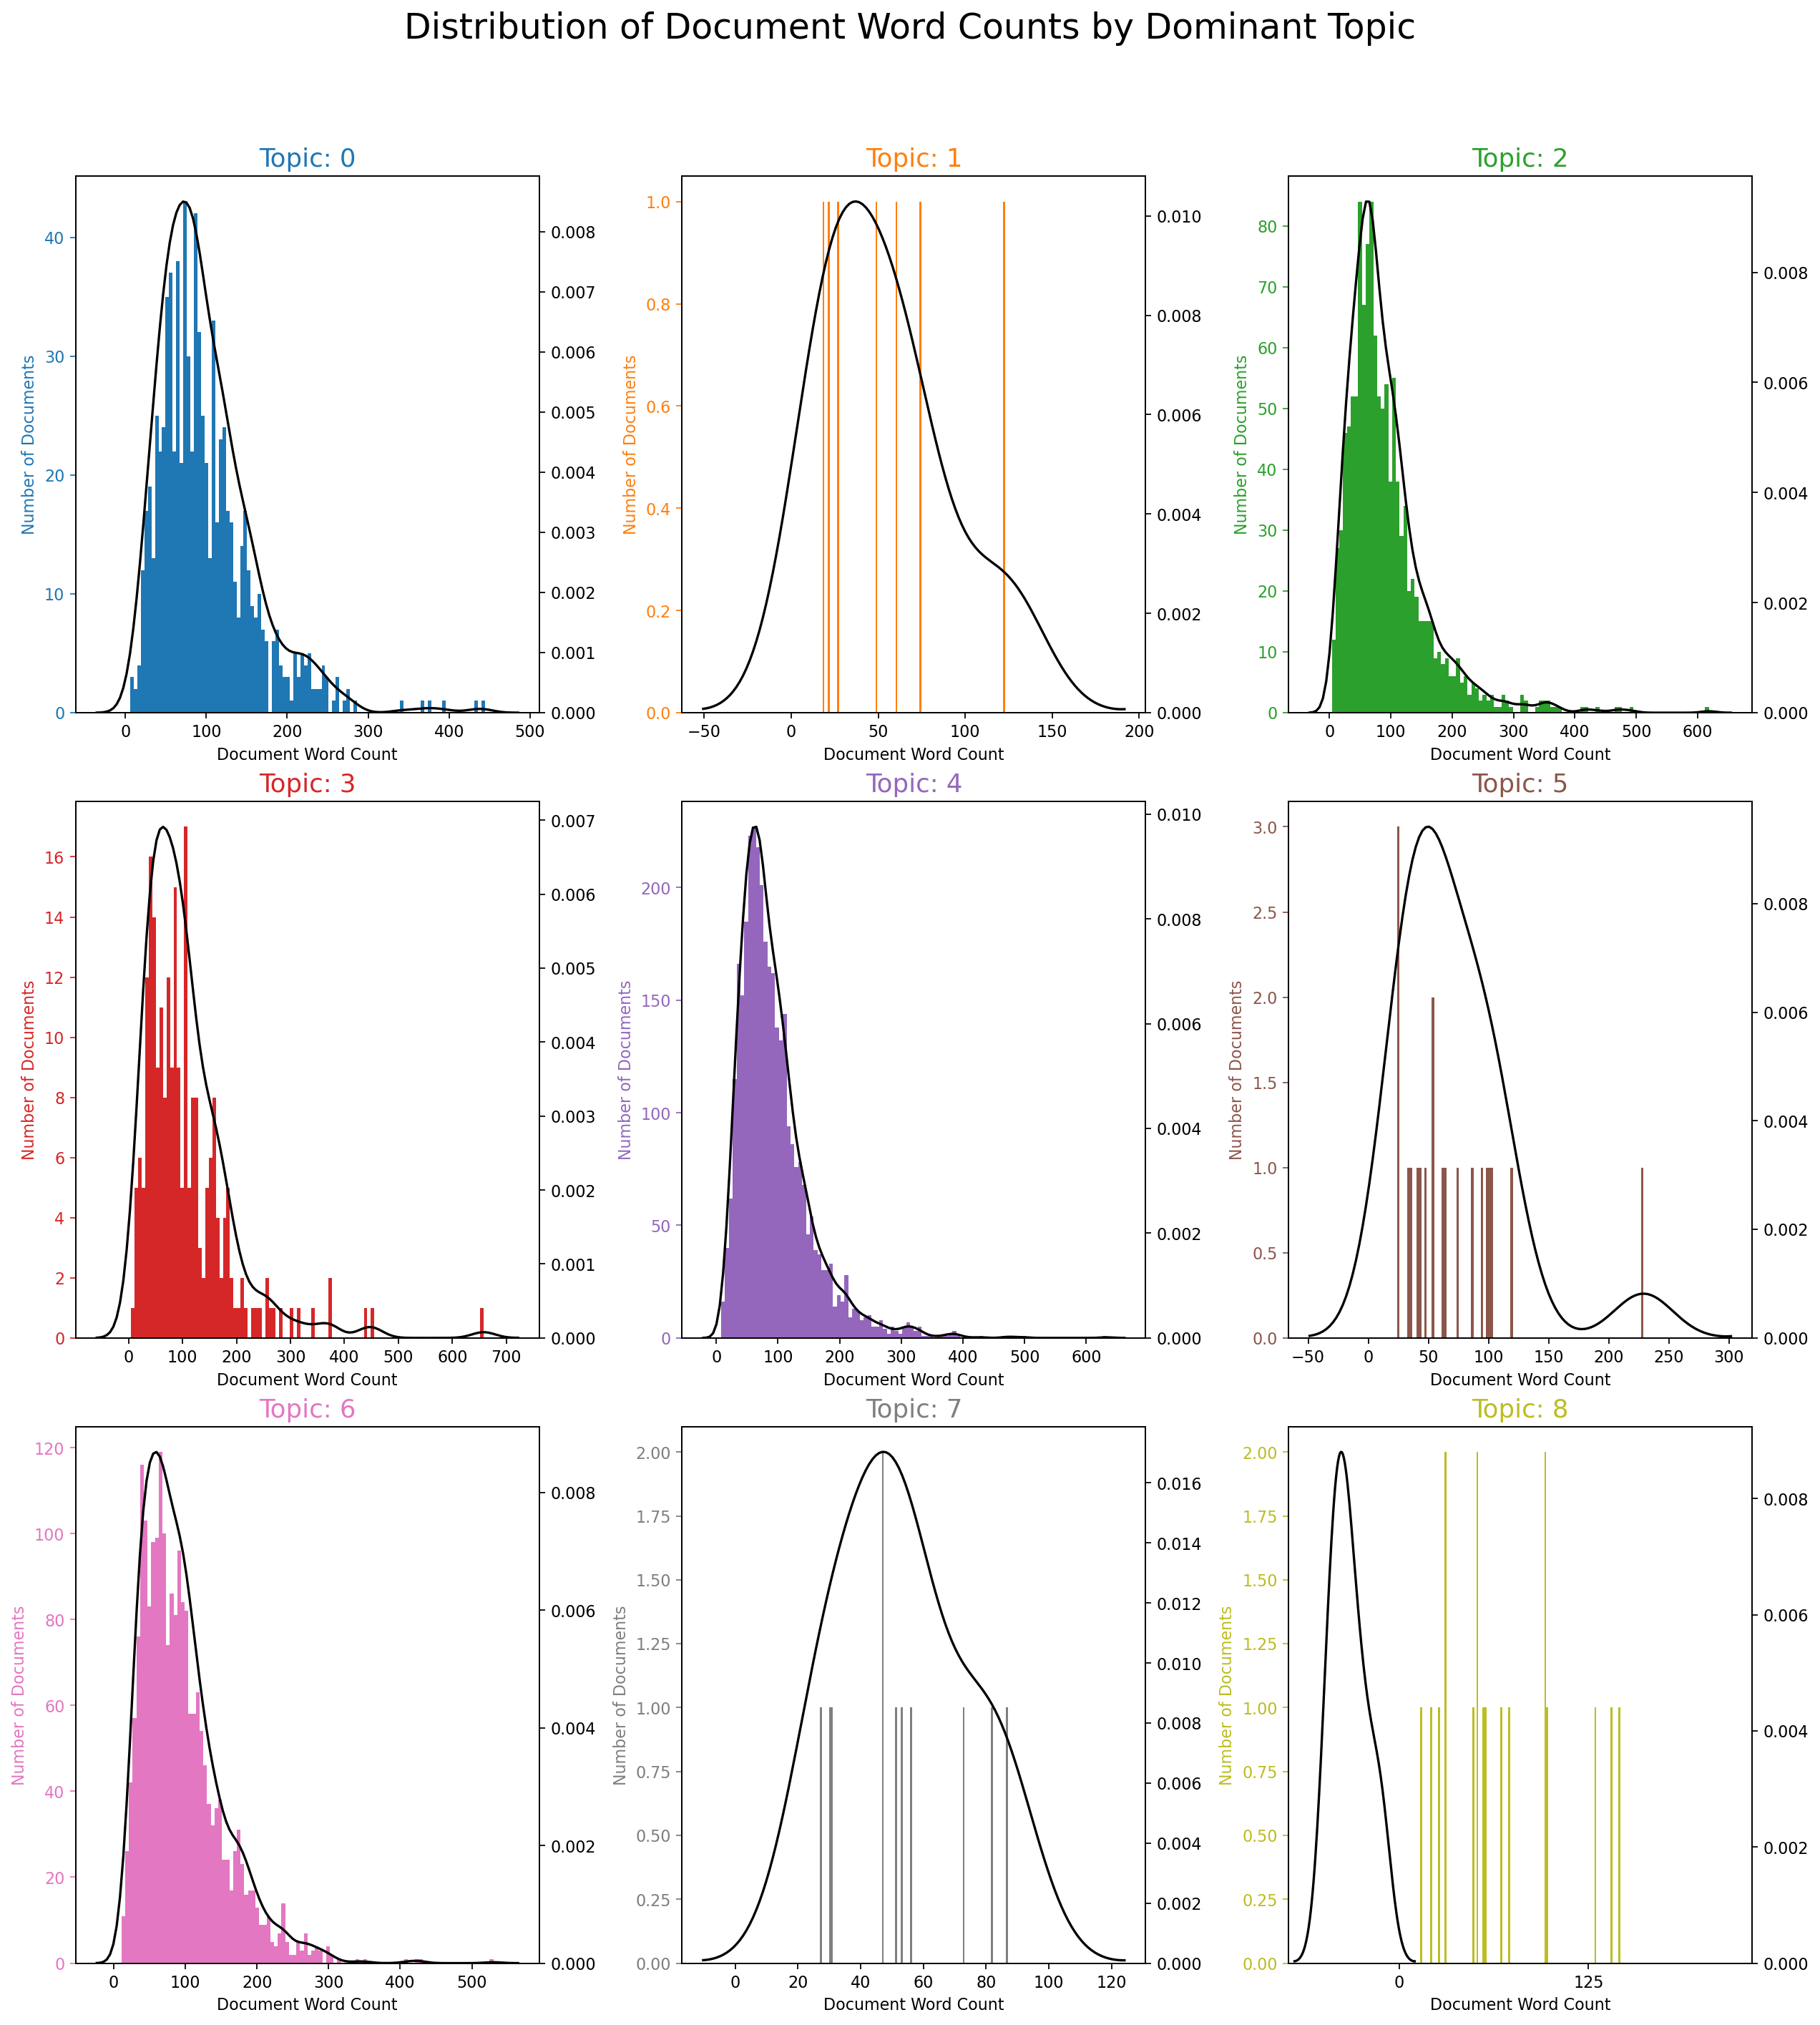

In [25]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(3,3,figsize=(16,18), dpi=160)

for i, ax in enumerate(axes.flatten()[:len(topics)]):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub['Text']]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

# This code below is to switch off the unnecessary axes
for ax in axes.flat[len(topics):]:
    ax.axis('off')
    
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

From the word frequency distribution plots, we can observe that the number of documents vary widely across the topics. Most of the topics have an average of about 100 words in the board game descriptions, while sparse topics have an average of about 50 words in the board game descriptions. As expected, the word frequency distributions have a high tendency of being right (positive) skewed.

#### Clustering Chart

We want to visualize the clusters of board game descriptions (documents) using the [t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm. It is a nonlinear dimensionality reduction technique mainly used for visualization in a low-dimensional space of two or three dimensions.

In [26]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [27]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5981 samples in 0.012s...
[t-SNE] Computed neighbors for 5981 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5981
[t-SNE] Computed conditional probabilities for sample 2000 / 5981
[t-SNE] Computed conditional probabilities for sample 3000 / 5981
[t-SNE] Computed conditional probabilities for sample 4000 / 5981
[t-SNE] Computed conditional probabilities for sample 5000 / 5981
[t-SNE] Computed conditional probabilities for sample 5981 / 5981
[t-SNE] Mean sigma: 0.058306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.366966
[t-SNE] KL divergence after 1000 iterations: 1.317328


Loading BokehJS ...

The cluster chart depicts similar objects using nearby points and dissimilar objects as distant points. We could clearly see the major clusters as differentiated by its colors, but may not be able to spot the topics which are sparse in terms of documents.

#### pyLDAvis

`pyLDAvis` is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

In [101]:
import pyLDAvis.gensim

In [112]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# uncomment to view
# vis

## Incorporation with Recommender

We want to include an option for users of our recommender system, on whether to diversify their recommendations based on the topics of each board game descriptions. It would cater to people who are seeking for diversity or serendipity, discovering board games possibly of a different concept from their input.

In [118]:
# Merge topic dataframe to games
new_df = game_df.copy()
new_df = new_df.merge(bg_df[['bgg_id', 'topic_no']], how='left', on='bgg_id')

with open('../datasets/boardgames/bgg_games_merged_topics.pkl', 'wb') as outfile:
    pickle.dump(new_df, outfile)